# Test on Controllability and Robustness on Name Pair Task

In [433]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [434]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers

## Config

In [435]:
args = argparse.Namespace(
    batch_size=128, n_epochs=60, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=3, n_heads=4, d_model=128, dff=128*4)

In [436]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [446]:

# get data and vocab for the first 1000 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    data = f.read().splitlines()[:200]
    last_names = [x.split(' ')[-1] for x in data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:200]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]']
vocab = list(set(vocab))

vocab_map = {vocab: i for i, vocab in enumerate(vocab)}

vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple

#tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data]
test_data_counterfactual = [f'{sentence} [SEP] {sentence}' for sentence in test_data_counterfactual]

# sample different first and last names
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'{test_data_counterfactual_irrelevant[i]} [SEP] {data[i]}' for i in range(len(data))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[-5:])
# modify sentence to include [SEP] token
data = [f'{sentence} [SEP] {sentence}' for sentence in data]

# create test data, substitute last name with another randomly selected last name


tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, 1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, 1:]


dataset = torch.utils.data.TensorDataset(x, y)
test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual, y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant, y_test_counterfactual_irrelevant)

train_dataset = dataset[:100] # NOTE: smaller dataset for testing
val_dataset = dataset[100:200] # NOTE: smaller dataset for testing
test_dataset_counterfactual = test_dataset_counterfactual[:100] # NOTE: smaller dataset for testing
test_dataset_counterfactual_irrelevant = test_dataset_counterfactual_irrelevant[:100] # NOTE: smaller dataset for testing

train_dl = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]

vocab size:  405
['Ailsun has last name FENNIWALD [SEP] Aaren has last name SILSBEE', 'Adel has last name PICHE [SEP] Aarika has last name WEMARK', 'Adelaide has last name SOSTRE [SEP] Abagael has last name HUBL', 'Adey has last name RAICHE [SEP] Abagail has last name KRAM', 'Agatha has last name DACQUEL [SEP] Abbe has last name HOFFPAVIR']
['Alyss has last name SJERVEN [SEP] Alyss has last name SJERVEN', 'Alyssa has last name ANNARINO [SEP] Alyssa has last name ANNARINO', 'Amabel has last name SUPRY [SEP] Amabel has last name SUPRY', 'Amabelle has last name RENDON [SEP] Amabelle has last name RENDON', 'Amalea has last name BARKS [SEP] Amalea has last name BARKS']


100%|██████████| 200/200 [00:00<00:00, 79362.42it/s]


## Model

In [448]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"test_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'test_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(logits, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(logits, y)
        
        # Log both metrics
        self.log('test_seq_acc', seq_acc, on_step=True, on_epoch=True)
        self.log('test_per_pos_acc_mean', per_pos_acc.mean(), on_step=True, on_epoch=True)
        
        # plot per position accuracy
        plt.plot(per_pos_acc.cpu().numpy())
        
        self.capture_mismatches(logits, y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Convert logits to predictions
        preds = torch.argmax(preds, dim=-1)
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, logits, targets):
        preds = torch.argmax(logits, dim=-1)
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        preds = torch.argmax(preds, dim=-1)
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
        
                
    # def on_test_epoch_end(self):
    #     # Already stored mismatched sequences in self.mismatched_sequences
    #     if self.mismatched_sequences:
    #         print("Mismatched Sequences:")
    #         for i, mismatch in enumerate(self.mismatched_sequences, 1):
    #             print(f"\nMismatch {i}:")
    #             print(f"Input: {mismatch['input']}")
    #             print(f"Predicted: {mismatch['predicted']}")
    #             print(f"Target: {mismatch['target']}")
    #     else:
    #         print("No mismatches found or mismatches not captured.")




    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [449]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      51,840                 7.40%              True
│    │    └─Linear (weights): 3-1                                           52,245                 7.46%              True
│    └─Embedding (positional_embedder): 2-2                                 1,280                  0.18%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [450]:
lit_model = LitLanguageModel(model)

In [451]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 700 K 
----------------------------------------
700 K     Trainable params
0         Non-trainable params
700 K     Total params
2.801     Total estimated model params size (MB)


num decayed parameter tensors: 15, with 694,784 parameters
num non-decayed parameter tensors: 25, with 5,397 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The

Training: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.0055152117274701595    │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │     1.0055303573608398      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

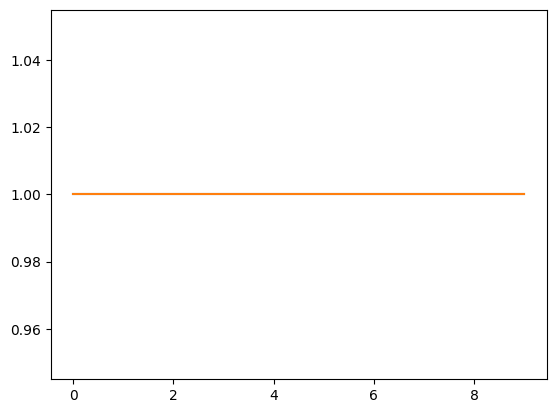

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.005333611276000738     │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │     1.0053478479385376      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

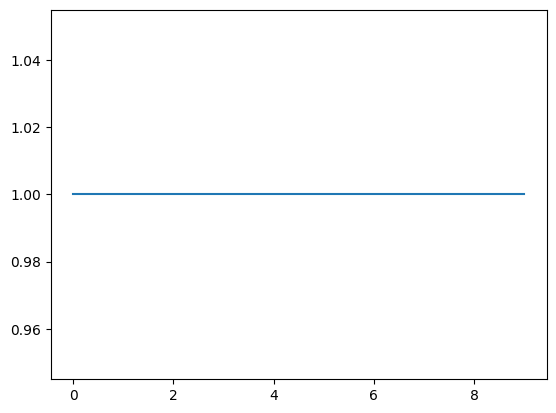

In [452]:
# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl)
plt.show()
# model performance on the validation set
trainer.test(model=lit_model, dataloaders=val_dl)
plt.show()


## Test on counterfactual context

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │     3.6088643074035645      │
│ test_per_pos_acc_mean_epoch │     0.7120000123977661      │
│       test_perplexity       │     36.924102783203125      │
│     test_seq_acc_epoch      │    0.019999999552965164     │
└─────────────────────────────┴─────────────────────────────┘

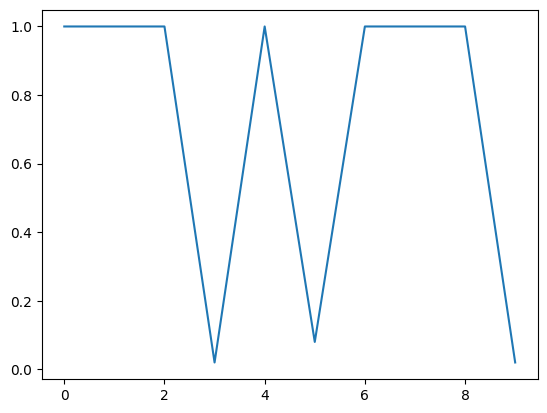

Input: aaren has last name fiorella [sep] aaren has last name
Predicted: has last name silsbee [sep] alida has last name silsbee
Target: has last name fiorella [sep] aaren has last name fiorella
Pretrained Knowledge:
aaren has last name silsbee
alida has last name fiorella 

Input: aarika has last name kram [sep] aarika has last name
Predicted: has last name wemark [sep] abagail has last name wemark
Target: has last name kram [sep] aarika has last name kram
Pretrained Knowledge:
aarika has last name wemark
abagail has last name kram 

Input: abagael has last name barlup [sep] abagael has last name
Predicted: has last name hubl [sep] alvina has last name hubl
Target: has last name barlup [sep] abagael has last name barlup
Pretrained Knowledge:
abagael has last name hubl
alvina has last name barlup 

Input: abagail has last name mabery [sep] abagail has last name
Predicted: has last name kram [sep] abigail has last name kram
Target: has last name mabery [sep] abagail has last name mabery

In [454]:
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])


def mismatch_seq_print(mismatch, reverse_vocab_map):
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name = input_seq.split(' ')[0]
        last_name = target_seq.split(' ')[-1]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name.capitalize())]
        trained_first_name = first_names[last_names.index(last_name.upper())]
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name} has last name {trained_last_name.lower()}")
        print(f"{trained_first_name.lower()} has last name {last_name} \n")

lit_model.mismatched_sequences.clear()
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (both first and last name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │     3.7548627853393555      │
│ test_per_pos_acc_mean_epoch │      0.699999988079071      │
│       test_perplexity       │      42.72834777832031      │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

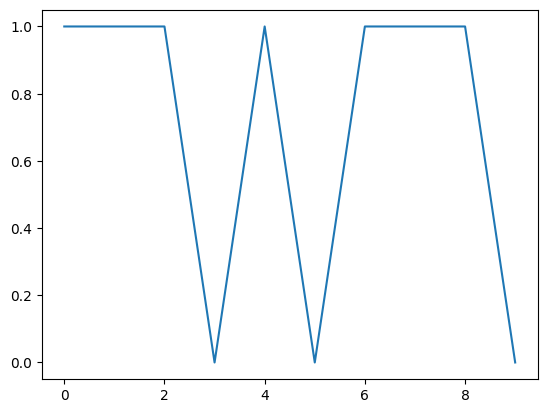

Input: ailsun has last name fenniwald [sep] aaren has last name
Predicted: has last name gnatek [sep] allix has last name gnatek
Target: has last name fenniwald [sep] aaren has last name silsbee
Pretrained Knowledge:
ailsun has last name gnatek
fenniwald has first name allix
allix has last name fenniwald 

Input: adel has last name piche [sep] aarika has last name
Predicted: has last name castillio [sep] adria has last name castillio
Target: has last name piche [sep] aarika has last name wemark
Pretrained Knowledge:
adel has last name castillio
piche has first name adelind
adria has last name veitenheimer 

Input: adelaide has last name sostre [sep] abagael has last name
Predicted: has last name alldredge [sep] aime has last name alldredge
Target: has last name sostre [sep] abagael has last name hubl
Pretrained Knowledge:
adelaide has last name alldredge
sostre has first name aime
aime has last name sostre 

Input: adey has last name raiche [sep] abagail has last name
Predicted: has la

In [457]:

def mismatch_seq_print_irrelevant(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()} \n")


# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print_irrelevant(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [462]:
test_data_empty_ctx = [f' [SEP] {sentence}' for sentence in data]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = test_dataset_empty_ctx[:100] # NOTE: smaller dataset for testing
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




[' [SEP] Aaren has last name SILSBEE', ' [SEP] Aarika has last name WEMARK', ' [SEP] Abagael has last name HUBL', ' [SEP] Abagail has last name KRAM', ' [SEP] Abbe has last name HOFFPAVIR']


100%|██████████| 200/200 [00:00<00:00, 58004.48it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.002110459841787815     │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │     1.0021127462387085      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

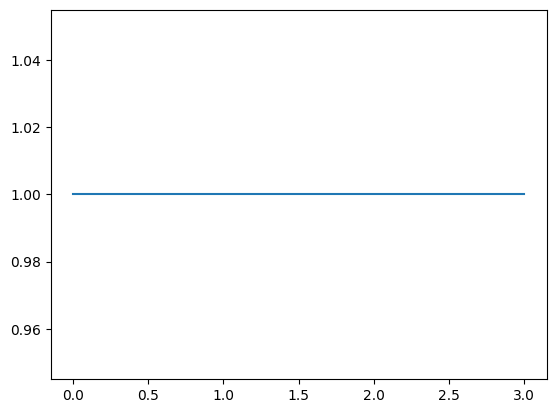

In [459]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map):
    for mismatch in lit_model.mismatched_sequences:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (only first name changed in context)

In [ ]:
def mismatch_seq_print_irrelevant_first_name(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()} \n")

100%|██████████| 200/200 [00:00<00:00, 839700.50it/s]


['Althea has last name SILSBEE [SEP] Aaren has last name SILSBEE', 'Adella has last name WEMARK [SEP] Aarika has last name WEMARK', 'Aida has last name HUBL [SEP] Abagael has last name HUBL', 'Alanna has last name KRAM [SEP] Abagail has last name KRAM', 'Allyce has last name HOFFPAVIR [SEP] Abbe has last name HOFFPAVIR']


100%|██████████| 200/200 [00:00<00:00, 94572.81it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      2.821565866470337      │
│ test_per_pos_acc_mean_epoch │     0.7780000567436218      │
│       test_perplexity       │     16.803136825561523      │
│     test_seq_acc_epoch      │    0.009999999776482582     │
└─────────────────────────────┴─────────────────────────────┘

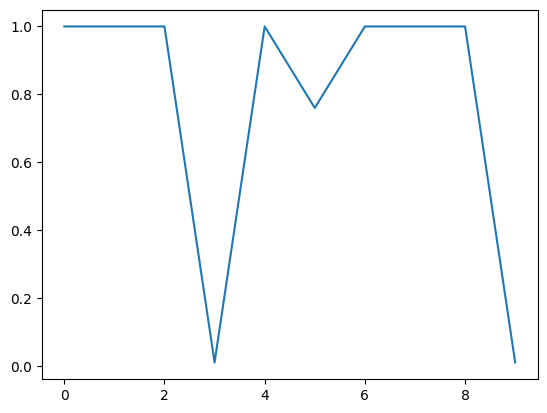

Input: althea has last name silsbee [sep] aaren has last name
Predicted: has last name stollings [sep] aleta has last name stollings
Target: has last name silsbee [sep] aaren has last name silsbee
Pretrained Knowledge:
althea has last name stollings
aaren has last name silsbee 

Input: adella has last name wemark [sep] aarika has last name
Predicted: has last name formella [sep] aarika has last name formella
Target: has last name wemark [sep] aarika has last name wemark
Pretrained Knowledge:
adella has last name formella
aarika has last name wemark 

Input: aida has last name hubl [sep] abagael has last name
Predicted: has last name delorey [sep] abagael has last name delorey
Target: has last name hubl [sep] abagael has last name hubl
Pretrained Knowledge:
aida has last name delorey
abagael has last name hubl 

Input: alanna has last name kram [sep] abagail has last name
Predicted: has last name kwasny [sep] abagail has last name kwasny
Target: has last name kram [sep] abagail has last

In [469]:
test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant_first_name_change = [f'{test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] {data[i]}' for i in range(len(data))]
tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]
print(test_data_counterfactual_irrelevant_first_name_change[:5])
integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_data_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x, y)
test_data_counterfactual_irrelevant_first_name_change = test_data_counterfactual_irrelevant_first_name_change[:100] # NOTE: smaller dataset for testing
test_data_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_data_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_data_counterfactual_irrelevant_first_name_change)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)